In [1]:
import requests
import json
import pandas as pd
import numpy as np

## 結果データを取得する

In [2]:
def getResultData(id):
    try:
        response = requests.get(f'http://localhost:5000/results/{id}')
        data = json.loads(response.text)
        
        #jsonデータをpandasのdataframeに変換する
        return data['data']
    except:
        throw('no id matches data in database')

getResultDataに渡すidはtherb-frontendのUIのここから取得できます
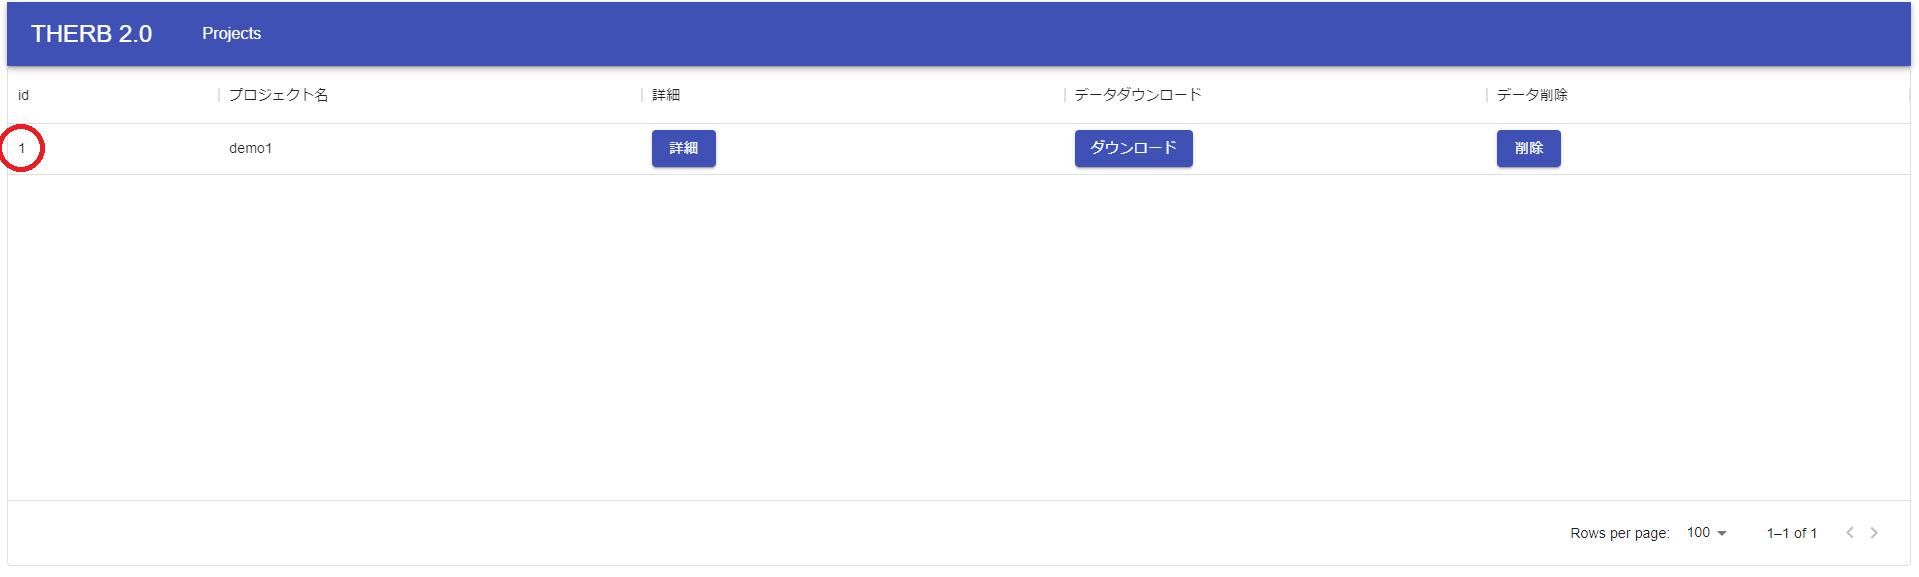

In [3]:
resultData = getResultData(5)

部屋ごとにデータを整理できるようにする必要

In [5]:
def convertToDataframe(resultDict):
    columns = []
    rows = []
    for k,v in resultDict.items():
        columns.append(k)
        rows.append(v)
    
    #transposedRows = np.array(rows,dtype=np.float32).T
    transposedRows = np.array(rows).T
    df = pd.DataFrame(data = transposedRows, columns = columns) 
    df=df.set_index('hour')
    df=df.astype('float32')
    #return transposedRows
    return df

In [10]:
df = convertToDataframe(resultData[0]['results'])

## とりあえず折れ線グラフで可視化してみる

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

### データをすぐに確認するのはpandasのほうが早い

<AxesSubplot:xlabel='hour'>

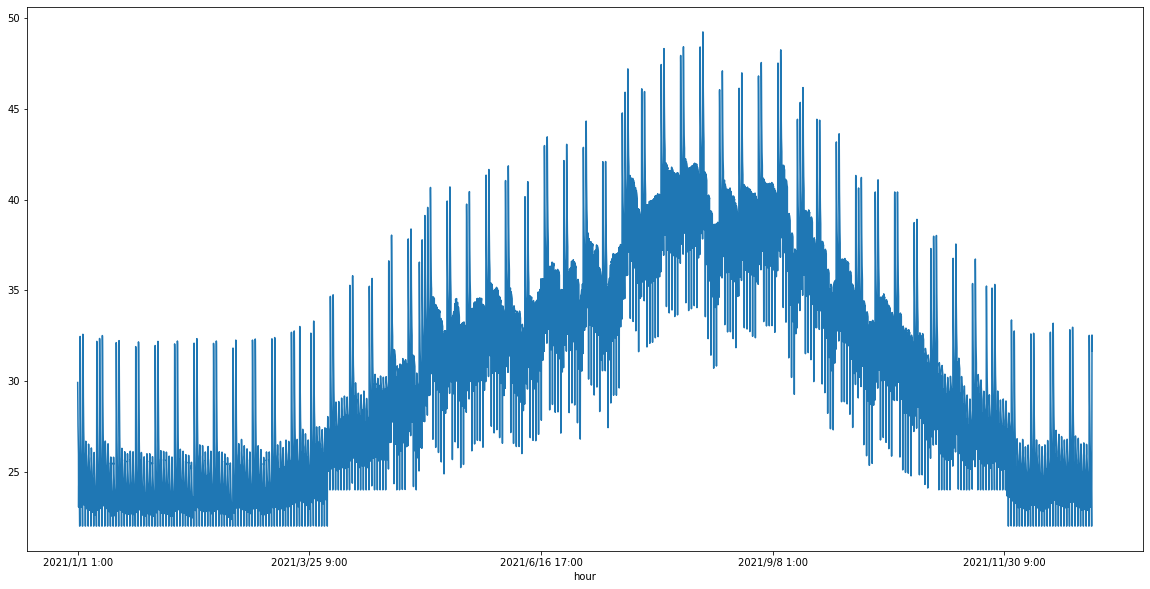

In [8]:
df['roomT'].plot.line(figsize=(20,10))

どの温度の時間帯が多いか？

<AxesSubplot:>

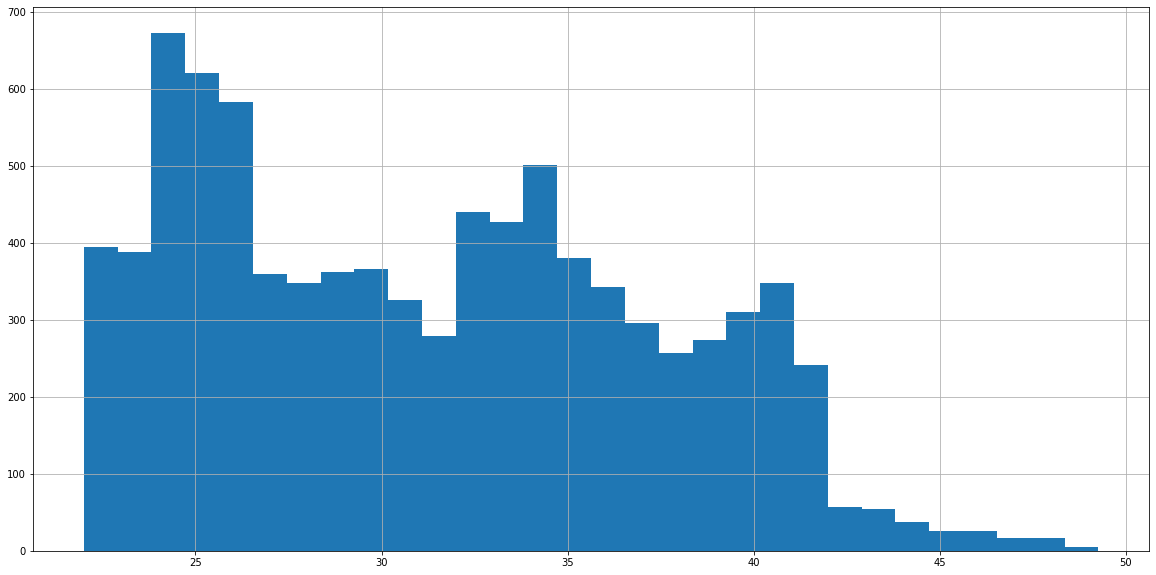

In [9]:
df['roomT'].hist(figsize=(20,10),bins=30)

### 快適時間帯の割合は？

In [127]:
def calcPercentage(data,min,max):
    maxSatisfied = data[lambda x: x<max]
    satisfied = maxSatisfied[lambda x: x>min]
    percentage = len(satisfied)/len(data)*100
    return round(percentage,1)

In [128]:
calcPercentage(df['roomT'],25,28)

18.1

### visualizeの見栄えをよくする

#### Seabornは時間がかかりすぎ

<AxesSubplot:xlabel='hour', ylabel='roomT'>

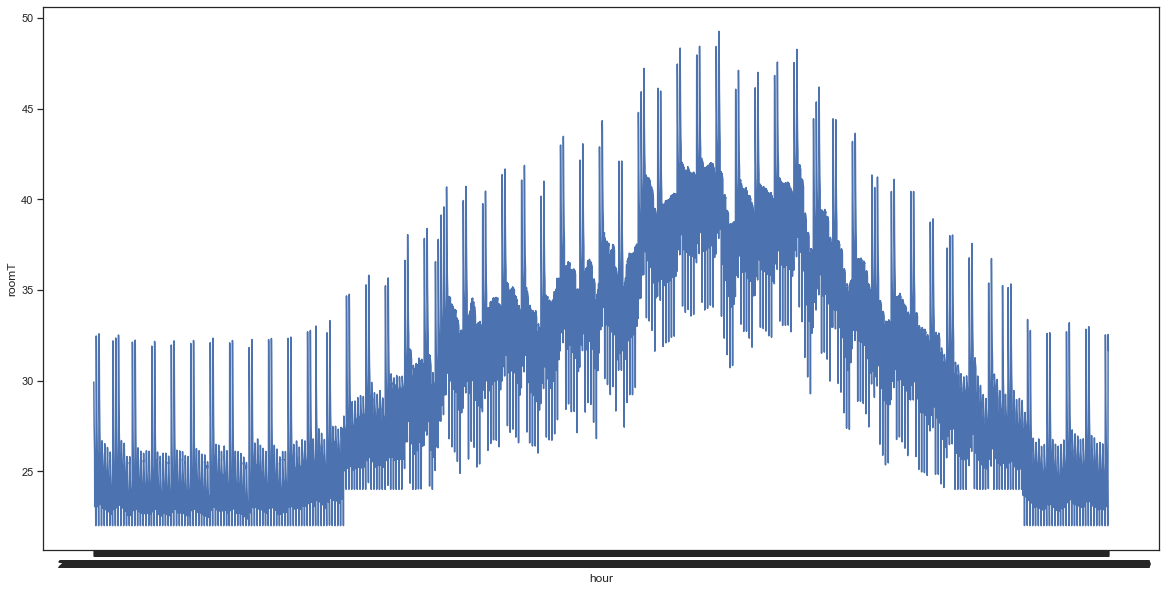

In [104]:
plt.figure(figsize=(20, 10))
sns.lineplot(data=df, x="hour", y="roomT")